# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

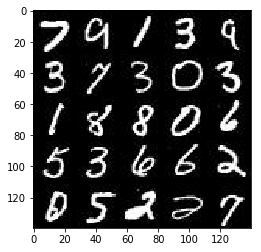

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

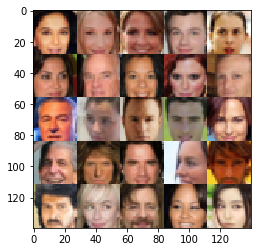

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """

    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim))
    lr = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Helpers

I wrote these to remove the deplicated code from all over the place and reduce copy-paste errors

In [6]:
def lrelu(tensor, alpha=0.2):
    """Calculate a leaky ReLU with the supplied tensor and alpha"""
    return tf.maximum(tensor, tensor * alpha)

In [7]:
def conv2d_leaky(inputs, outputs, kernel_size=5, strides=2, padding='same', alpha=0.2):
    layer = tf.layers.conv2d(inputs, outputs, kernel_size, strides, padding)
    return lrelu(layer, alpha) if alpha != -1 else layer

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    keep_prob = 0.8

    # image shape: batch_count, 28, 28, 3
    with tf.variable_scope('discriminator', reuse=reuse):
        
        conv0 = conv2d_leaky(images, 32, strides=1, padding='same')
        conv0 = tf.nn.dropout(conv0, keep_prob)
        
        conv1 = conv2d_leaky(images, 64, strides=2, padding='same')
        conv1 = tf.layers.batch_normalization(conv1, training=False)
        conv1 = tf.nn.dropout(conv1, keep_prob)
        # now 14x14x64

        conv2 = conv2d_leaky(conv1, 128)
        conv2 = tf.layers.batch_normalization(conv2, training=False)
        conv2 = tf.nn.dropout(conv2, keep_prob)
        # now 7x7x128
                
        conv3 = conv2d_leaky(conv2, 256, strides=2, padding='same')
        conv3 = tf.layers.batch_normalization(conv3, training=False)
        conv3 = tf.nn.dropout(conv3, keep_prob)
        # now 4x4x256
        
        conv4 = conv2d_leaky(conv3, 512, strides=1, padding='same')
        conv4 = tf.layers.batch_normalization(conv4, training=False)
        conv4 = tf.nn.dropout(conv4, keep_prob)
        
        
        flat = tf.reshape(conv4, (-1, 2 * 2 * 512))
        
        logits = tf.layers.dense(flat, 1)
        out = tf.nn.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # notes to self:
    keep_prob = 0.8 # this is the default of tf.layers.dropout and a "first attempt guess"
    # we can set alpha later
    
    # why the opposite???
    with tf.variable_scope('generator', reuse=not is_train):

        x1 = tf.layers.dense(z, 7 * 7 * 512,
                             kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                             activation=tf.nn.relu)
        

        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.layers.dropout(x1, keep_prob)
        # 7x7x512 now

        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                        activation=tf.nn.relu)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.layers.dropout(x2, keep_prob)
        # 14x14x256 now

        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                        activation=tf.nn.relu)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.layers.dropout(x3, keep_prob)
        # 28x28x128 now
        
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=1, padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                        activation=tf.nn.relu)
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.layers.dropout(x4, keep_prob)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=1, padding='same', 
                                            kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    # encapsulate the repeated logic
    def model_loss(logits, like_shape_for_labels, smoothing=1):
        return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=like_shape_for_labels))
    
    smoothing = 0.9 # factor to help with generalization
    
    # now actually calculate those losses
    d_loss_real = model_loss(d_logits_real, tf.ones_like(d_model_real) * smoothing)

    d_loss_fake = model_loss(d_logits_fake, tf.zeros_like(d_model_fake))
    g_loss = model_loss(d_logits_fake, tf.ones_like(d_model_fake))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    trainables = tf.trainable_variables()
    d_vars = [var for var in trainables if var.name.startswith('discriminator')]
    g_vars = [var for var in trainables if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [ ]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model

    print("parameters:")
    print("\t epoch_count =", epoch_count)
    print("\t batch_size =", batch_size)
    print("\t z_dim =", z_dim)
    print("\t learning_rate =", learning_rate)
    print("\t beta1 =", beta1)
    print("\t data_shape =", data_shape)
    print("\t image_mode =", data_image_mode)
    
    data_set_size, width, height, channels = data_shape
    
    input_real, input_z, lr = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    step = 0
    print_every = 25
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                step += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Optimizers do their thing
                _ = sess.run(d_opt, feed_dict={ input_z: batch_z, input_real: batch_images, lr: learning_rate })
                _ = sess.run(g_opt, feed_dict={ input_z: batch_z, input_real: batch_images, lr: learning_rate})
                
                if step % print_every == 0:
                    train_loss_d = d_loss.eval({ input_z: batch_z, input_real: batch_images })
                    train_loss_g = g_loss.eval({ input_z: batch_z })

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if step % show_every == 0:
                    show_generator_output(sess, 10, input_z, channels, data_image_mode)

    # No return value because we are just churning on the data

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

parameters:
	 epoch_count = 2
	 batch_size = 64
	 z_dim = 100
	 learning_rate = 0.0002
	 beta1 = 0.5
	 data_shape = (60000, 28, 28, 1)
	 image_mode = L
Epoch 1/2... Discriminator Loss: 0.3710... Generator Loss: 3.6884
Epoch 1/2... Discriminator Loss: 1.3444... Generator Loss: 0.7216
Epoch 1/2... Discriminator Loss: 1.4348... Generator Loss: 0.5558
Epoch 1/2... Discriminator Loss: 1.3661... Generator Loss: 0.7112


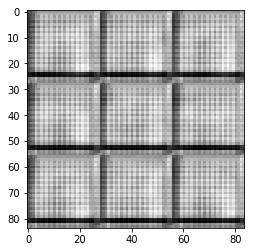

Epoch 1/2... Discriminator Loss: 1.4525... Generator Loss: 0.7479
Epoch 1/2... Discriminator Loss: 1.4491... Generator Loss: 0.7669
Epoch 1/2... Discriminator Loss: 1.4160... Generator Loss: 0.8576
Epoch 1/2... Discriminator Loss: 1.4014... Generator Loss: 0.7040


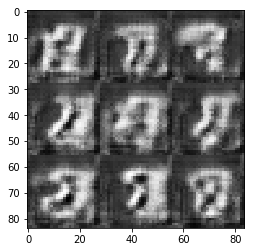

Epoch 1/2... Discriminator Loss: 1.2305... Generator Loss: 0.9916
Epoch 1/2... Discriminator Loss: 1.2762... Generator Loss: 0.9239
Epoch 1/2... Discriminator Loss: 1.3486... Generator Loss: 0.9791
Epoch 1/2... Discriminator Loss: 1.4777... Generator Loss: 0.5950


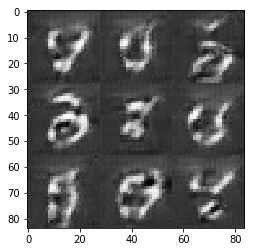

Epoch 1/2... Discriminator Loss: 1.3735... Generator Loss: 0.7679
Epoch 1/2... Discriminator Loss: 1.3856... Generator Loss: 0.7576
Epoch 1/2... Discriminator Loss: 1.3683... Generator Loss: 0.8695
Epoch 1/2... Discriminator Loss: 1.3586... Generator Loss: 0.7834


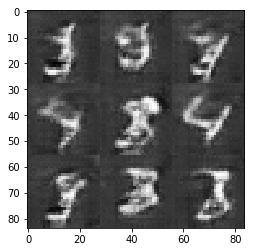

Epoch 1/2... Discriminator Loss: 1.4853... Generator Loss: 0.4748
Epoch 1/2... Discriminator Loss: 1.4025... Generator Loss: 0.7726
Epoch 1/2... Discriminator Loss: 1.2133... Generator Loss: 1.1716
Epoch 1/2... Discriminator Loss: 1.3768... Generator Loss: 0.6348


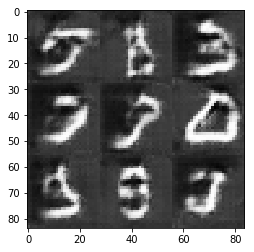

Epoch 1/2... Discriminator Loss: 1.3817... Generator Loss: 0.7975
Epoch 1/2... Discriminator Loss: 1.4690... Generator Loss: 0.5260
Epoch 1/2... Discriminator Loss: 1.4202... Generator Loss: 0.6506
Epoch 1/2... Discriminator Loss: 1.3669... Generator Loss: 0.7998


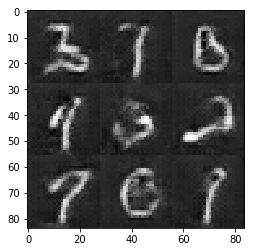

Epoch 1/2... Discriminator Loss: 1.3616... Generator Loss: 0.7352
Epoch 1/2... Discriminator Loss: 1.0147... Generator Loss: 1.4249
Epoch 1/2... Discriminator Loss: 1.4447... Generator Loss: 0.7119
Epoch 1/2... Discriminator Loss: 1.4141... Generator Loss: 0.7419


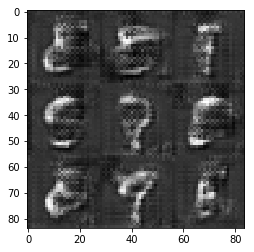

Epoch 1/2... Discriminator Loss: 1.3980... Generator Loss: 0.7613
Epoch 2/2... Discriminator Loss: 1.3433... Generator Loss: 0.7533
Epoch 2/2... Discriminator Loss: 1.4475... Generator Loss: 0.8229


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

parameters:
	 epoch_count = 1
	 batch_size = 64
	 z_dim = 200
	 learning_rate = 0.0002
	 beta1 = 0.8
	 data_shape = (202599, 28, 28, 3)
	 image_mode = RGB
Epoch 1/1... Discriminator Loss: 0.4171... Generator Loss: 2.9986
Epoch 1/1... Discriminator Loss: 0.5935... Generator Loss: 2.4875
Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 0.7649
Epoch 1/1... Discriminator Loss: 1.2191... Generator Loss: 1.0883


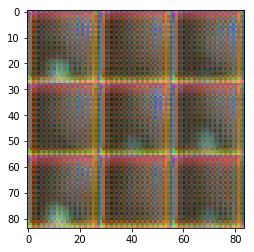

Epoch 1/1... Discriminator Loss: 1.4457... Generator Loss: 0.9288
Epoch 1/1... Discriminator Loss: 1.4463... Generator Loss: 1.1060
Epoch 1/1... Discriminator Loss: 1.2870... Generator Loss: 0.8888
Epoch 1/1... Discriminator Loss: 1.3576... Generator Loss: 0.8294


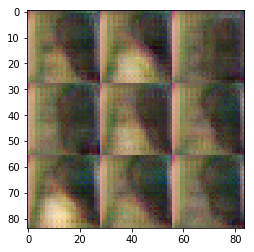

Epoch 1/1... Discriminator Loss: 1.4487... Generator Loss: 0.7600
Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 0.7296
Epoch 1/1... Discriminator Loss: 1.4933... Generator Loss: 0.5825
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.8703


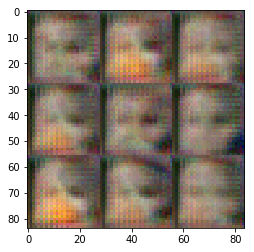

Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 1.3549... Generator Loss: 0.8310
Epoch 1/1... Discriminator Loss: 1.3566... Generator Loss: 0.8488
Epoch 1/1... Discriminator Loss: 1.5415... Generator Loss: 0.7868


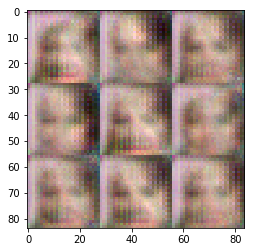

Epoch 1/1... Discriminator Loss: 1.3373... Generator Loss: 0.8885
Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 0.7681
Epoch 1/1... Discriminator Loss: 1.3099... Generator Loss: 0.8708
Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.7619


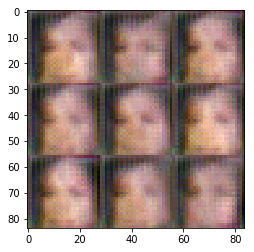

Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.7804
Epoch 1/1... Discriminator Loss: 1.3586... Generator Loss: 0.8696
Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.8782
Epoch 1/1... Discriminator Loss: 1.3717... Generator Loss: 0.7775


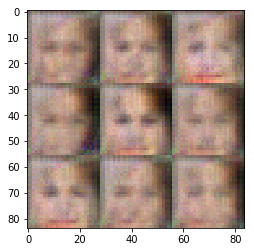

Epoch 1/1... Discriminator Loss: 1.5013... Generator Loss: 0.6549
Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.7995
Epoch 1/1... Discriminator Loss: 1.2569... Generator Loss: 0.7733
Epoch 1/1... Discriminator Loss: 1.5112... Generator Loss: 0.5439


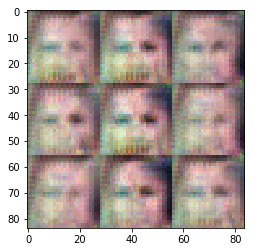

Epoch 1/1... Discriminator Loss: 1.3600... Generator Loss: 0.7791
Epoch 1/1... Discriminator Loss: 1.7046... Generator Loss: 1.1967
Epoch 1/1... Discriminator Loss: 1.0209... Generator Loss: 0.9757
Epoch 1/1... Discriminator Loss: 1.5126... Generator Loss: 0.9719


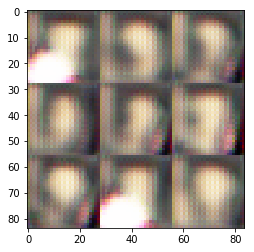

Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 0.7675
Epoch 1/1... Discriminator Loss: 1.3063... Generator Loss: 1.1199
Epoch 1/1... Discriminator Loss: 1.3588... Generator Loss: 0.7548
Epoch 1/1... Discriminator Loss: 1.3711... Generator Loss: 0.7960


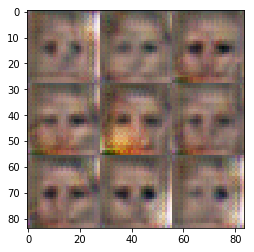

Epoch 1/1... Discriminator Loss: 1.4099... Generator Loss: 0.8008
Epoch 1/1... Discriminator Loss: 1.7790... Generator Loss: 0.4219
Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 0.8960
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.7927


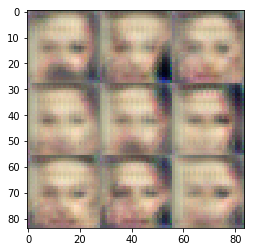

Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.7842
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.7945
Epoch 1/1... Discriminator Loss: 1.3661... Generator Loss: 0.7728
Epoch 1/1... Discriminator Loss: 1.4586... Generator Loss: 0.6389


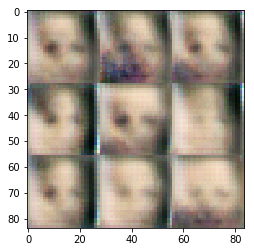

Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.7851
Epoch 1/1... Discriminator Loss: 1.4863... Generator Loss: 0.7340
Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 0.8301
Epoch 1/1... Discriminator Loss: 1.3614... Generator Loss: 0.6725


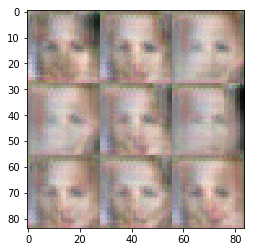

Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.8395
Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.7326
Epoch 1/1... Discriminator Loss: 1.3419... Generator Loss: 0.6411
Epoch 1/1... Discriminator Loss: 1.3361... Generator Loss: 0.7992


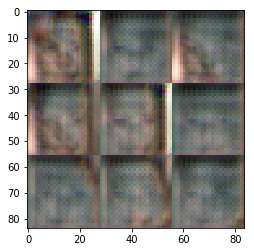

Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.7631
Epoch 1/1... Discriminator Loss: 1.3116... Generator Loss: 0.8646
Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.8478
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.8897


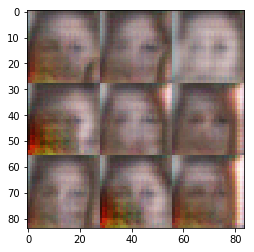

Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.7905
Epoch 1/1... Discriminator Loss: 1.3608... Generator Loss: 0.8408
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.7934
Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.7576


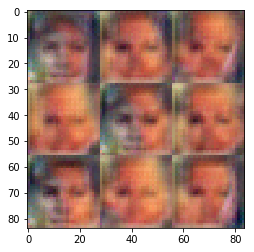

Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.7838
Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 0.7624
Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 0.7438
Epoch 1/1... Discriminator Loss: 1.3537... Generator Loss: 0.8025


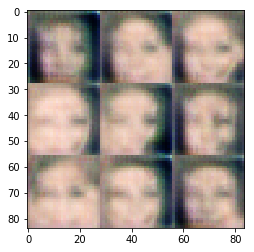

Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.7551
Epoch 1/1... Discriminator Loss: 1.3791... Generator Loss: 0.8002
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.7732
Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.8260


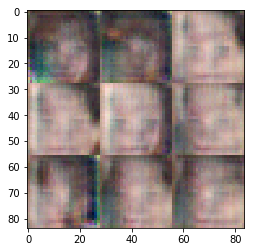

Epoch 1/1... Discriminator Loss: 1.3623... Generator Loss: 0.7917
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.8018
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.7917
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.7591


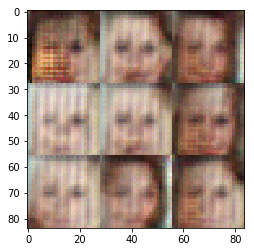

Epoch 1/1... Discriminator Loss: 1.3825... Generator Loss: 0.8099
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.7977
Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.8158
Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.7953


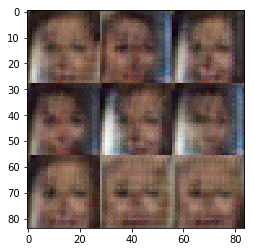

In [ ]:
batch_size = 64 # see slack #project-5
z_dim = 200
learning_rate = 0.0002
beta1 = 0.8


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.